<a href="https://colab.research.google.com/github/ravindrabharathi/Project1/blob/master/session16/TF_records_DNST_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Using TFRecords and DenseNet for CIFAR-10 image classification

### chose tensorflow 2 in colab

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

TensorFlow 2.x selected.


### import necessary modules 

In [0]:

#from keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D,  Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.optimizers import Adam

import numpy as np

### set memory allocation config when backend is tf version <2 

In [0]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
#use if tf version <2 
if (int(str(tf.__version__)[:1])<2):
  import keras
  from keras import backend as k

  # Don't pre-allocate memory; allocate as-needed
  config = tf.ConfigProto()
  config.gpu_options.allow_growth = True

  # Create a session with the above options specified.
  k.tensorflow_backend.set_session(tf.Session(config=config))

### set hyperparameters like epochs , batch_size , number of filters to be used in DenseNET Conv layers , Dropout rate etc

In [0]:
# Hyperparameters
batch_size = 128
num_classes = 10
epochs = 50
l = 40
num_filter = 12
compression = 0.5
dropout_rate = 0.2

### creation of tfrecords , reading from tfrecords as tf dataset , etc have been defined in this file named [tf_utils.py](https://) . Download and import the utility functions 

In [6]:
!curl --user ravindrabharathi 'https://raw.githubusercontent.com/ravindrabharathi/Project1/master/utils/tf_utils.py?' > tf_utils.py

Enter host password for user 'ravindrabharathi':
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  8792  100  8792    0     0  29904      0 --:--:-- --:--:-- --:--:-- 29904


### import tf_utils , it checks for the number of cpus so that we may use it for parallel calls to read records in tfrecords

In [7]:
import tf_utils

Finished 'get_cpu_num' in 0.0000 secs


### get CIFAR10 Data and creat TFRecords 

In [8]:
tf_utils.get_cifar10_and_create_tfrecords()


Finished 'download_file' in 2.4938 secs
Finished 'download_cifar10_files' in 2.4943 secs
Done
Finished 'extract_cifar10_files' in 1.8787 secs
Finished '_get_file_names' in 0.0000 secs
Generating ./train.tfrecords
Finished 'read_pickle_from_file' in 0.1566 secs
Finished 'read_pickle_from_file' in 0.1532 secs
Finished 'read_pickle_from_file' in 0.1451 secs
Finished 'read_pickle_from_file' in 0.1433 secs
Finished 'read_pickle_from_file' in 0.1447 secs
Finished 'convert_to_tfrecord' in 3.8639 secs
Done!
Generating ./eval.tfrecords
Finished 'read_pickle_from_file' in 0.1439 secs
Finished 'convert_to_tfrecord' in 0.7733 secs
Done!
Finished 'create_tf_records' in 4.6393 secs
Finished 'get_cifar10_and_create_tfrecords' in 9.0129 secs


### Create tf Data datasets from the TFRecords . One for training data and another for eval data 

In [9]:
#train_dataset, eval_dataset= cifar10_tf_records.create_datasets()

train_ds=tf_utils.get_train_ds()

test_ds=tf_utils.get_eval_ds()


Finished 'get_tf_dataset' in 4.1776 secs
Finished 'get_tf_dataset_in_batches' in 4.1776 secs
Finished 'get_train_ds' in 4.1780 secs
Finished 'get_tf_dataset' in 0.0253 secs
Finished 'get_tf_dataset_in_batches' in 0.0254 secs
Finished 'get_eval_ds' in 0.0257 secs


### plot some images from the datasets to make sure we have not messed up the images 

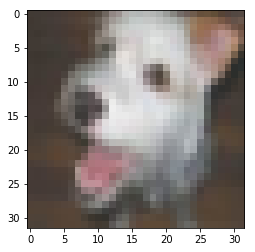

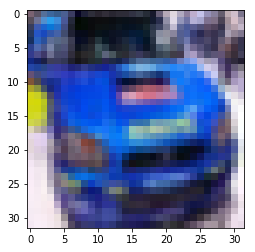

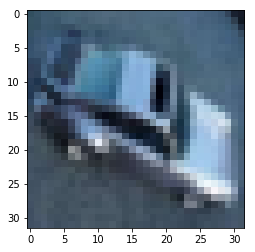

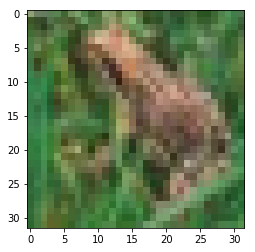

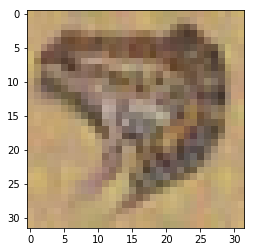

In [10]:
tf_utils.plot_cifar10_files(train_ds)

### Define the various components on the DenseNet Model 

#### Dense Block



In [0]:
# Dense Block
def add_denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l):
        BatchNorm = BatchNormalization()(temp)
        relu = Activation('relu')(BatchNorm)
        Conv2D_3_3 = Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
          Conv2D_3_3 = Dropout(dropout_rate)(Conv2D_3_3)
        concat = Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

#### Transition Block

In [0]:
def add_transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
      Conv2D_BottleNeck = Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    
    return avg

#### Output layer 

In [0]:
def output_layer(input):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    AvgPooling = AveragePooling2D(pool_size=(2,2))(relu)
    flat = Flatten()(AvgPooling)
    output = Dense(num_classes, activation='softmax')(flat)
    
    return output

#### Now that we have defined the components , build the model 

In [0]:
num_filter = 12
dropout_rate = 0.2
l = 12

input = Input(shape=(32,32,3))
First_Conv2D = Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = add_denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = add_transition(First_Block, num_filter, dropout_rate)

Second_Block = add_denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = add_transition(Second_Block, num_filter, dropout_rate)

Third_Block = add_denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = add_transition(Third_Block, num_filter, dropout_rate)

Last_Block = add_denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)


In [15]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 12)   324         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 12)   48          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 12)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

#### compile the model 

In [0]:
# determine Loss function and Optimizer
opt=tf.compat.v1.keras.optimizers.Adam()
model.compile(loss='categorical_crossentropy',
              optimizer='adam',metrics=['accuracy']
              )

#### train the model for 50 epochs 

In [17]:
model_history=model.fit(train_ds,epochs=50, steps_per_epoch=np.ceil(50000/batch_size), 
          validation_data=test_ds, validation_steps=np.ceil(10000/batch_size),
          verbose=1)

Train for 391.0 steps, validate for 79.0 steps
Epoch 1/50
391/391 [==============================] - 98s 251ms/step - loss: 1.7506 - accuracy: 0.3410 - val_loss: 2.0442 - val_accuracy: 0.3090
Epoch 2/50
391/391 [==============================] - 81s 207ms/step - loss: 1.3949 - accuracy: 0.4868 - val_loss: 1.5550 - val_accuracy: 0.4767
Epoch 3/50
391/391 [==============================] - 81s 207ms/step - loss: 1.2385 - accuracy: 0.5470 - val_loss: 1.2147 - val_accuracy: 0.5795
Epoch 4/50
391/391 [==============================] - 81s 207ms/step - loss: 1.1374 - accuracy: 0.5880 - val_loss: 1.4948 - val_accuracy: 0.4855
Epoch 5/50
391/391 [==============================] - 81s 208ms/step - loss: 1.0606 - accuracy: 0.6182 - val_loss: 1.6715 - val_accuracy: 0.5255
Epoch 6/50
391/391 [==============================] - 81s 208ms/step - loss: 1.0023 - accuracy: 0.6397 - val_loss: 1.0904 - val_accuracy: 0.6327
Epoch 7/50
391/391 [==============================] - 81s 208ms/step - loss: 0.9677

#### the training time per epoch was around 150sec without using tfRecords . This has reduced to 81 seconds when using tfrecords

#### evaluate the model and print accuracy score 

In [18]:
# Test the model
score = model.evaluate(test_ds, steps =np.ceil(10000/batch_size), verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

79/79 [==============================] - 4s 52ms/step - loss: 0.8182 - accuracy: 0.7632
Test loss: 0.8182164996485167
Test accuracy: 0.7631527


#### save the model 

In [19]:
# Save the trained weights in to .h5 format
model.save_weights("DNST_model.h5")
print("Saved model to disk")

Saved model to disk


#### We have now completed the first step in building an effective data pipeline for training CNN . We will build on this further by adding Image Augmentation and also ability to handle more datasets (right now it is cifar 10) in the next few iterations 